In [26]:
import csv
import folium
import matplotlib.pyplot as pl
import matplotlib.patches as mpatches

# sklearn: 
# Import necessary packages
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import *
import plotly.graph_objs as go
import plotly as plt
import seaborn as sns
import numpy as np
import glob

import matplotlib.pyplot as plt
import seaborn as sns

# suppress all warnings
import warnings
warnings.filterwarnings("ignore")


# folium: 
from folium import plugins
from folium.plugins import HeatMap

In [27]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [84]:
accidents= pd.read_csv('gdrive/MyDrive/Road Safety Data Accident 2019.csv', low_memory=False,dtype={'Accident_index':'int','LSOA_of_Accident_Location':'str'})

In [85]:
vehicles= pd.read_csv('gdrive/MyDrive/Road Safety Data Vehicles 2019.csv', low_memory=False,dtype={'Accident_index':'int'})

In [86]:
casualties= pd.read_csv('gdrive/MyDrive/Road Safety Data Casualties 2019.csv', low_memory=False,dtype={'Accident_index':'int'})

# **DATA CLEANING/ PREPROCESSING**

In [87]:
accidents['Date']= pd.to_datetime(accidents['Date'], format="%d/%m/%Y")

In [88]:
accidents.replace(-1, 'NaN', inplace=True)
casualties.replace(-1, 'NaN', inplace=True)
vehicles.replace(-1, 'NaN', inplace=True)

In [89]:
#time series features: 
accidents['Year'] = accidents.Date.dt.year 
accidents['Month_number'] = accidents.Date.dt.month
accidents['Month'] = accidents.Date.dt.month_name()
accidents['Hour'] = accidents.apply(lambda x: str(x.Time).split(':')[0], axis=1)

In [90]:
accidents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117536 entries, 0 to 117535
Data columns (total 36 columns):
 #   Column                                       Non-Null Count   Dtype         
---  ------                                       --------------   -----         
 0   Accident_Index                               117536 non-null  object        
 1   Location_Easting_OSGR                        117508 non-null  float64       
 2   Location_Northing_OSGR                       117508 non-null  float64       
 3   Longitude                                    117508 non-null  float64       
 4   Latitude                                     117508 non-null  float64       
 5   Police_Force                                 117536 non-null  int64         
 6   Accident_Severity                            117536 non-null  int64         
 7   Number_of_Vehicles                           117536 non-null  int64         
 8   Number_of_Casualties                         117536 non-null  in

In [91]:
accidents = pd.merge(accidents,vehicles[['Accident_Index','Vehicle_Type','Sex_of_Driver', 'Age_of_Driver', 'Age_Band_of_Driver','Vehicle_Manoeuvre', 'Age_of_Vehicle']],on='Accident_Index', how='left')


In [92]:
accidents_cleanup = ['Longitude', 'Latitude','Time','Number_of_Casualties','Speed_limit', 'Junction_Detail', 'Light_Conditions', 'Road_Type',
                          'Did_Police_Officer_Attend_Scene_of_Accident','Weather_Conditions', 
                          'Road_Surface_Conditions', 'Special_Conditions_at_Site','Carriageway_Hazards', 
                          'Urban_or_Rural_Area', 'Accident_Severity', '1st_Road_Class', 
                          'Pedestrian_Crossing-Human_Control', 
                          'Pedestrian_Crossing-Physical_Facilities', 
                          'Police_Force' ,'Age_of_Driver', 
                          'Vehicle_Manoeuvre','LSOA_of_Accident_Location']

accidents_cleanup_outliers = ['Sex_of_Driver', 'Age_Band_of_Driver']
outliers_list = ['6 - 10', '0 - 5', 'Not known']

In [93]:
# method to clean spesific features, and remove linked data points in other datasets: 
def clean_data (cleanup_features, df, df2, df3): 
    for feature in cleanup_features: 
        accidents_data_list = df[(df[feature].isnull()) | (df[feature] == 'NaN')].Accident_Index.tolist()
        df = df[~df.Accident_Index.isin(accidents_data_list)]
        df2 = df2[~df2.Accident_Index.isin(accidents_data_list)]
        df3 = df3[~df3.Accident_Index.isin(accidents_data_list)]
    return df, df2, df3

In [94]:
# method to remove outliers from spesific features, and remove linked data points in other datasets: 
def clean_outliers (cleanup_outliers, outliers_list, df, df2, df3): 
    for feature in cleanup_outliers: 
        accidents_data_list = df[(df[feature].isin (outliers_list))].Accident_Index.tolist()
        df = df[~df.Accident_Index.isin(accidents_data_list)]
        df2 = df2[~df2.Accident_Index.isin(accidents_data_list)]
        df3 = df3[~df3.Accident_Index.isin(accidents_data_list)]
    return df, df2, df3

In [95]:
# remove dublicate 
accidents.drop_duplicates(subset='Accident_Index', keep='first', inplace=True)

In [96]:
print ('accidents_data drop duplicates:', accidents.shape[0])
print ('casualties_data drop duplicates:', casualties.shape[0])
print ('vehicles_data drop duplicates:', vehicles.shape[0])

accidents_data drop duplicates: 117536
casualties_data drop duplicates: 153158
vehicles_data drop duplicates: 216381


In [97]:
# removing rows with missing values/outliers and their linked vehicles/casualties data
accidents, casualties, vehicles = clean_data(accidents_cleanup, accidents, casualties, vehicles)
accidents, casualties, vehicles = clean_outliers(accidents_cleanup_outliers, outliers_list, accidents, casualties, vehicles)

In [98]:
# convert new column to numeric datetype
accidents['Hour'] = pd.to_numeric(accidents['Hour'])

# drop null values in our new column
accidents = accidents.dropna(subset=['Hour'])

# cast to integer values
accidents['Hour'] = accidents['Hour'].astype('int')

In [99]:
# define a function that turns the hours into daytime groups
def when_was_it(hour):
    if hour >= 5 and hour < 10:
        return "1"
    elif hour >= 10 and hour < 15:
        return "2"
    elif hour >= 15 and hour < 19:
        return "3"
    elif hour >= 19 and hour < 23:
        return "4"
    else:
        return "5"

In [100]:
# create a little dictionary to later look up the groups 
daytime_groups = {1: 'Morning: Between 5 and 10', 
                  2: 'Office Hours: Between 10 and 15', 
                  3: 'Afternoon Rush: Between 15 and 19', 
                  4: 'Evening: Between 19 and 23', 
                  5: 'Night: Between 23 and 5'}

In [101]:
#created a temporary column
accidents['Day_time'] = accidents['Hour'].apply(when_was_it)
accidents[['Time', 'Hour', 'Day_time']].head(20)

,Time,Hour,Day_time
4,01:50,1,5
6,01:20,1,5
7,00:40,0,5
9,02:45,2,5
11,01:35,1,5
12,02:10,2,5
15,01:15,1,5
17,04:30,4,5
20,01:15,1,5
21,03:00,3,5


In [102]:
# drop old time column and temporary hour column
accidents = accidents.drop(columns=['Time', 'Hour'])

In [103]:
accidents = accidents.dropna()

In [104]:
#for col in set(accidents.columns) - set(accidents.describe().columns):
    #accidents[col] = accidents[col].astype('category')

In [106]:
# combine the accidents with the vehicles table
df_M = pd.merge(accidents[['Accident_Index', 'Accident_Severity','Day_time', 'Location_Northing_OSGR', 'Special_Conditions_at_Site','Longitude', 'Latitude','Speed_limit', 'Urban_or_Rural_Area', 'Location_Easting_OSGR', 'Weather_Conditions','Did_Police_Officer_Attend_Scene_of_Accident', 'Pedestrian_Crossing-Human_Control', 
                          'Pedestrian_Crossing-Physical_Facilities','Number_of_Casualties','Road_Surface_Conditions', 'Road_Type', 'Light_Conditions']], 
              vehicles[['Accident_Index', 'Vehicle_Type','Vehicle_Manoeuvre','Was_Vehicle_Left_Hand_Drive?','Sex_of_Driver', 'Age_Band_of_Driver']],
              
              on='Accident_Index')

In [107]:
Merged = pd.merge(df_M, casualties, on='Accident_Index')

In [108]:
# combine the accidents with the vehicles table
df_M = pd.merge(Merged[['Accident_Index', 'Did_Police_Officer_Attend_Scene_of_Accident','Longitude', 'Latitude', 'Special_Conditions_at_Site',
                      'Pedestrian_Crossing-Physical_Facilities','Day_time','Age_Band_of_Driver', 'Pedestrian_Location', 'Pedestrian_Movement', 'Location_Northing_OSGR', 'Location_Easting_OSGR','Speed_limit', 'Urban_or_Rural_Area', 'Weather_Conditions', 'Number_of_Casualties','Road_Surface_Conditions', 'Road_Type', 'Light_Conditions']], 
              casualties[['Accident_Index', 'Casualty_Type','Casualty_Severity','Sex_of_Casualty', 'Age_of_Casualty']],
              
              on='Accident_Index')

df_M.isna().sum()

Accident_Index                                 0
Did_Police_Officer_Attend_Scene_of_Accident    0
Longitude                                      0
Latitude                                       0
Special_Conditions_at_Site                     0
Pedestrian_Crossing-Physical_Facilities        0
Day_time                                       0
Age_Band_of_Driver                             0
Pedestrian_Location                            0
Pedestrian_Movement                            0
Location_Northing_OSGR                         0
Location_Easting_OSGR                          0
Speed_limit                                    0
Urban_or_Rural_Area                            0
Weather_Conditions                             0
Number_of_Casualties                           0
Road_Surface_Conditions                        0
Road_Type                                      0
Light_Conditions                               0
Casualty_Type                                  0
Casualty_Severity   

In [109]:
# define categorical feature columns
category_cols = ['Urban_or_Rural_Area','Age_Band_of_Driver','Special_Conditions_at_Site','Did_Police_Officer_Attend_Scene_of_Accident', 'Longitude', 'Latitude','Pedestrian_Movement', 
                 'Speed_limit', 'Weather_Conditions', 'Number_of_Casualties','Road_Surface_Conditions', 'Road_Type', 'Light_Conditions']

# define target col
target_col = ['Day_time']

cols = category_cols  + target_col

# copy dataframe - just to be safe
df = df_M[cols].copy()
df.shape

(463217, 14)

In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 463217 entries, 0 to 463216
Data columns (total 14 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   Urban_or_Rural_Area                          463217 non-null  int64  
 1   Age_Band_of_Driver                           463217 non-null  object 
 2   Special_Conditions_at_Site                   463217 non-null  object 
 3   Did_Police_Officer_Attend_Scene_of_Accident  463217 non-null  int64  
 4   Longitude                                    463217 non-null  float64
 5   Latitude                                     463217 non-null  float64
 6   Pedestrian_Movement                          463217 non-null  int64  
 7   Speed_limit                                  463217 non-null  object 
 8   Weather_Conditions                           463217 non-null  int64  
 9   Number_of_Casualties                         463217 non-nul

In [54]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import *

In [111]:
category_cols

['Urban_or_Rural_Area',
 'Age_Band_of_Driver',
 'Special_Conditions_at_Site',
 'Did_Police_Officer_Attend_Scene_of_Accident',
 'Longitude',
 'Latitude',
 'Pedestrian_Movement',
 'Speed_limit',
 'Weather_Conditions',
 'Number_of_Casualties',
 'Road_Surface_Conditions',
 'Road_Type',
 'Light_Conditions']

In [112]:
#create dummy variables from the categorical features
dummies = pd.get_dummies(df[category_cols], drop_first=True)
df = pd.concat([ df[target_col], dummies], axis=1)
df.shape

(463217, 40)

In [113]:
# Train Test Split
y = df['Day_time']
X = df.drop('Day_time', axis=1)

In [58]:
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from matplotlib import pyplot
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

# **MODELLING**

In [59]:
def get_dataset():
    X_train, X_validation, y_train, y_validation = train_test_split(X,y,test_size=.25,random_state=1)
    return X_train, y_train

In [60]:
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, 
error_score='raise')
    return scores

In [61]:
def get_models():
    models = dict()
    models['dtree'] = DecisionTreeClassifier()
    models['knn'] = KNeighborsClassifier()
    models['lr'] = LogisticRegression()
    models['rcf'] = RandomForestClassifier()
    models['nb'] = MultinomialNB()
    
    
    return models

In [62]:
X, y = get_dataset()
#Grab the models to use.
models = get_models()
#Run and Evaluate the models.
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

>dtree 0.862 (0.003)
>knn 0.749 (0.002)
>lr 0.404 (0.003)
>rcf 0.844 (0.002)


ValueError: ignored

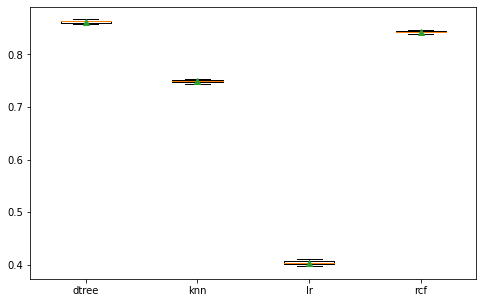

In [63]:
plt.figure(figsize=(8,5))

pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [ ]:
#concate scores & columns
#fscores= pd.concat([dcolumns, dscores], axis=1)
#fscores.columns = ['Feature', 'Score']
#fscores.sort_values(by='Score', ascending = False, ignore_index=True)

**SINCE RANDOM FOREST WORKS WELL WITH IMBALNCED DATASET AND ALSO PRODUCED A GOOD RESULT UPON STACKING WITH OTHER MODELS, I WILL PROCEED WITH THE MODELLING WITH RANDOM FOREST**

In [114]:
from sklearn.model_selection import train_test_split

# split our data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [115]:
# import classifier
from sklearn.ensemble import RandomForestClassifier

# import metrics
from sklearn.metrics import classification_report, confusion_matrix

# import evaluation tools
from sklearn.model_selection import KFold, cross_val_score

In [116]:
# instantiate RandomForestClassifier with entropy and class_weight
forest_1 = RandomForestClassifier(random_state=42, n_estimators=100, n_jobs=-1)

# train
forest_1.fit(X_train, y_train)

# predict
y_test_preds  = forest_1.predict(X_test)

# evaluate
report = classification_report(y_test, y_test_preds)
print('Classification Report Random Forest -: \n', report)

Classification Report Random Forest - with Entropy: 
               precision    recall  f1-score   support

           1       0.82      0.78      0.80     15535
           2       0.86      0.88      0.87     27535
           3       0.84      0.85      0.84     29082
           4       0.86      0.87      0.86     13638
           5       0.90      0.84      0.87      6854

    accuracy                           0.85     92644
   macro avg       0.85      0.84      0.85     92644
weighted avg       0.85      0.85      0.85     92644



In [117]:
# cross-validation with F1 score (more appropriate to imbalanced classes)
cross_val_score(forest_1, X_train, y_train, scoring='f1_macro', n_jobs=-1)

array([0.8422797 , 0.84116772, 0.84131165, 0.84410674, 0.84033321])

In [68]:
#Time_of_day_Pred= forest_1.predict_proba(X_test)[:,1]

In [70]:
#Doc_result = pd.DataFrame({'id': X_test.index, 'RandonForest': Time_of_day_Pred})

#Doc_result

,id,RandonForest
0,96286,0.00
1,35605,0.95
2,394443,0.14
3,3609,0.69
4,102246,0.00
...,...,...
69478,121730,0.45
69479,12908,0.32
69480,34242,0.00
69481,177265,0.54


In [ ]:
#Time2_result= pd.DataFrame(forest_2.predict_proba(X_test), columns=['Morning', 'Office rush', 'Afternoon','Evening','Night'])      #this is the predicted probability for all classes

In [119]:
pwd

'/content'

In [118]:
import sklearn.metrics as metrics


In [120]:
cf_matrix = metrics.confusion_matrix(y_test, y_test_preds)
print(cf_matrix)

[[12180  1554  1452   277    72]
 [ 1190 24249  1936   141    19]
 [ 1159  2173 24640   873   237]
 [  221   324   934 11809   350]
 [   70    31   342   627  5784]]


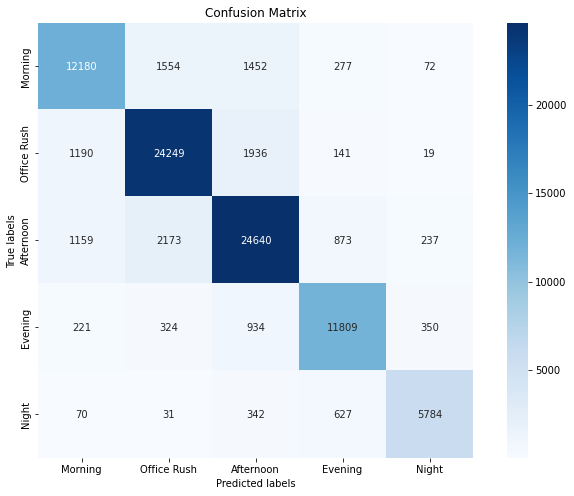

In [121]:
#confusion matrix
plt.figure(figsize=(12,8))
sns.heatmap(cf_matrix, square=True, annot=True, cmap='Blues',fmt='d',cbar=True);

ax= plt.subplot()
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Morning', 'Office Rush', 'Afternoon', 'Evening', 'Night']); ax.yaxis.set_ticklabels(['Morning', 'Office Rush', 'Afternoon', 'Evening', 'Night']);

**Training Random Forest Classifier with SMOTE**

In [122]:
from imblearn.over_sampling import SMOTE


In [123]:
# view previous class distribution
print('Before Upsampling with SMOTE:'), print(df['Day_time'].value_counts())

oversample = SMOTE()
X_resample, y_resample = oversample.fit_resample(X, y)

# view synthetic sample class distribution
print('\nAfter Upsampling with SMOTE:'), print(pd.Series(y_resample).value_counts())

Before Upsampling with SMOTE:
3    145008
2    137670
1     77449
4     69137
5     33953
Name: Day_time, dtype: int64

After Upsampling with SMOTE:
5    145008
1    145008
2    145008
3    145008
4    145008
Name: Day_time, dtype: int64


(None, None)

In [124]:
# then perform ususal train-test-split
X_train, X_test, y_train, y_test = train_test_split(X_resample, y_resample, random_state=0)


In [125]:
# instantiate second RandomForestClassifier with entropy and SMOTE
forest_2 = RandomForestClassifier(random_state=42, n_estimators=100, n_jobs=-1)

# train
forest_2.fit(X_train, y_train)

# predict
y_test_preds = forest_2.predict(X_test)

# evaluate
report = classification_report(y_test, y_test_preds)
print('Classification Report Random Forest - and SMOTE Upsampling: \n', report)

Classification Report Random Forest - and SMOTE Upsampling: 
               precision    recall  f1-score   support

           1       0.85      0.88      0.86     36277
           2       0.87      0.87      0.87     36092
           3       0.87      0.83      0.85     36323
           4       0.91      0.91      0.91     36203
           5       0.94      0.95      0.95     36365

    accuracy                           0.89    181260
   macro avg       0.89      0.89      0.89    181260
weighted avg       0.89      0.89      0.89    181260



In [126]:
cf_matrix = metrics.confusion_matrix(y_test, y_test_preds)
print(cf_matrix)

[[31890  1912  1567   643   265]
 [ 2522 31310  1827   343    90]
 [ 2239  2211 29969  1324   580]
 [  773   574   876 32846  1134]
 [  266   148   319  1070 34562]]


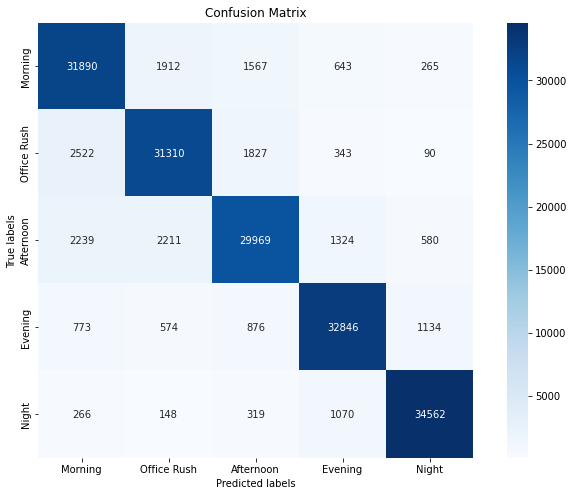

In [127]:
plt.figure(figsize=(12,8))
sns.heatmap(cf_matrix, square=True, annot=True, cmap='Blues',fmt='d',cbar=True);
ax= plt.subplot()
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Morning', 'Office Rush', 'Afternoon', 'Evening', 'Night']); ax.yaxis.set_ticklabels(['Morning', 'Office Rush', 'Afternoon', 'Evening', 'Night']);

In [129]:
data= df_M

In [130]:
#arcquiring the predictions
rf_model_pred = forest_2.predict_proba(X_test)

Time_preds = pd.DataFrame(data=rf_model_pred, columns = ['Morning', 'Office Rush', 'Afternoon', 'Evening', 'Night'], index=X_test.index.copy())

# y_test['preds'] = rf_model_pred

Time_pred = pd.merge(data , Time_preds, left_index=True, right_index=True)

In [132]:
#this is the predicted probability for all classes
Time_Pred = Time_pred[['Accident_Index','Morning', 'Office Rush', 'Afternoon', 'Evening', 'Night']]

In [133]:
Time_Pred

,Accident_Index,Morning,Office Rush,Afternoon,Evening,Night
0,2019010155191,0.06,0.00,0.02,0.31,0.61
5,2019010155195,0.00,0.00,0.00,0.00,1.00
7,2019010155196,0.00,0.00,0.00,0.00,1.00
13,2019010155207,0.00,0.00,0.00,0.00,1.00
19,2019010155220,0.00,0.00,0.00,0.00,1.00
...,...,...,...,...,...,...
169609,201963DF02519,0.06,0.94,0.00,0.00,0.00
169611,201963DF02719,0.06,0.94,0.00,0.00,0.00
169613,201963DF02719,0.01,0.99,0.00,0.00,0.00
169617,201963DF02919,0.42,0.37,0.19,0.02,0.00


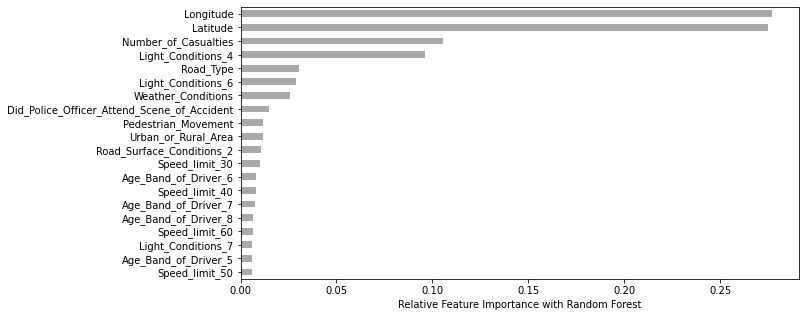

In [128]:
# plot the important features
feat_importances = pd.Series(forest_2.feature_importances_, index=X.columns)
feat_importances.nlargest(20).sort_values().plot(kind='barh', color='darkgrey', figsize=(10,5))
plt.xlabel('Relative Feature Importance with Random Forest');